In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize']=(12,8)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
feature_descriptions={'State':'Customer’s state',
'Account Length':'Integer number showing the duration of activity for customer account',
'Area Code':'Area code of customer',
'Phone':'Phone number of customer',
"Int'l Plan":'Binary indicator showing whether the customer has international calling plan',
'VMail Plan':'Indicator of voice mail plan',
'VMail Message':'The number of voicemail messages',
'Day Mins':'The number of minutes the customer used the service during day time',
'Day Calls':'Discrete attribute indicating the total number of calls during day time',
'Day Charge':'Charges for using the service during day time',
'Eve Mins':'The number of minutes the customer used the service during evening time',
'Eve Calls':' The number of calls during evening time',
'Eve Charge':' Charges for using the service during evening time',
'Night Mins':' Number of minutes the customer used the service during night time',
'Night Calls':'The number of calls during night time',
'Night Charge':'Charges for using the service during night time',
'Intl Mins':'Number of minutes the customer used the service to make international calls',
'Intl Calls':'The number of international calls',
'Intl Charge':'Charges for international calls',
'CustServ Calls':'The number of calls to customer support service'
}

# Import dataset

In [42]:
df=pd.read_csv('churn.csv')

# Data Transformation

### Transform phone and binary attributes

In [43]:
df['Phone_Number']='('+df['Area Code'].astype('str')+')'+df['Phone']
df["Int'l Plan"]=df["Int'l Plan"].apply(lambda i:0 if i=="no" else 1)
df['VMail Plan']=df['VMail Plan'].apply(lambda i:0 if i=="no" else 1)
df['Churn?']=df['Churn?'].apply(lambda c:0 if c=="False." else 1)

In [44]:
df.index=df['Phone_Number']
df=df.drop(columns=['Area Code','Phone','Phone_Number'])

### Divide into attributes and class

In [45]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

### Encoding State column

In [46]:
X=pd.get_dummies(X,columns=['State'])

### Splitting the dataset into the Training set and Test set

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [48]:
phone_numbers=X_test.index.tolist()

# Building model using Decision Tree

### Training the Decision Tree Classification model on the Training set

In [49]:
def decision_tree_class():
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    return classifier

In [50]:
dt_class=decision_tree_class()

In [51]:
def generate_dt_dashboard():
    explainer_dt_all = ClassifierExplainer(dt_class, X_test, y_test, 
                                    descriptions=feature_descriptions,
                                    labels=['Not Churn', 'Churn'], 
                                    cats=['State'],
                                    idxs = phone_numbers, 
                                    index_name = "Phone Number", 
                                    target = "Churn", 
                                    )
    db_dt_all=ExplainerDashboard(explainer_dt_all, 
                            title="Churn Prediction by Decision Tree", 
                            shap_interaction=False,
                            )
    db_dt_all.run(port=8050)

### Making the Confusion Matrix for Decision Tree

In [52]:
def cm_scores(classifier):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()
    print(cm)
    print(' ')
    print('True Positive is {}.'.format(tp))
    print('True Negative is {}.'.format(tn))
    print('False Positive is {}.'.format(fp))
    print('False Negative is {}.\n'.format(fn))
    accuracy=round(accuracy_score(y_test, y_pred),2)
    recall=round(recall_score(y_test,y_pred),2)
    precision=round(precision_score(y_test,y_pred),2)
    print('Accuracy is {}.'.format(accuracy))
    print('Recall is {}.'.format(recall))
    print('Precision is {}.\n'.format(precision))
    return tn,fp,fn,tp,accuracy,recall,precision

In [53]:
dt_tn,dt_fp,dt_fn,dt_tp,dt_accuracy,dt_recall,dt_precision=cm_scores(dt_class)

[[1077   75]
 [  51  131]]
 
True Positive is 131.
True Negative is 1077.
False Positive is 75.
False Negative is 51.

Accuracy is 0.91.
Recall is 0.72.
Precision is 0.64.



### Visualize the importances of attributes

In [54]:
importance_dt=dt_class.feature_importances_

In [55]:
def get_importance(importance):
    import_df=pd.DataFrame(importance,index=X.columns)
    state_importance=0
    new_import_df=import_df.copy()
    for i in import_df.index.tolist():
        if 'State' in i:
            state_importance+=import_df[0][i]
            new_import_df=new_import_df.drop(i,axis=0)
    new_import_df=new_import_df.append(pd.DataFrame([state_importance],index=['State']))
    new_import_df=new_import_df.sort_values(by=0,ascending=False)
    ind=new_import_df.index.tolist()
    return ind,new_import_df

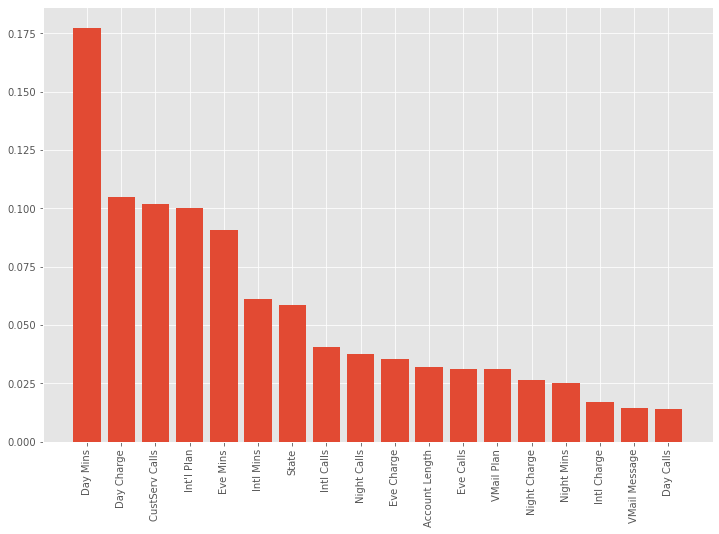

In [56]:
ind_dt,new_import_df_dt=get_importance(importance_dt)
plt.bar([x for x in range(len(new_import_df_dt))], new_import_df_dt[0])
plt.xticks([i for i in range(len(ind_dt))],ind_dt,rotation=90)
plt.show()

# Building model using Naive Bayes

### Training the Naive Bayes Classification model on the Training set

In [57]:
def naive_bayes_class():
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    return classifier

In [58]:
nb_class=naive_bayes_class()

In [59]:
def generate_nb_dashboard():
    explainer_nb_all = ClassifierExplainer(nb_class, X_test, y_test, 
                                    descriptions=feature_descriptions,
                                    labels=['Not Churn', 'Churn'], 
                                    cats=['State'],
                                    idxs = phone_numbers, 
                                    index_name = "Phone Number", 
                                    target = "Churn", 
                                    )
    db_nb_all=ExplainerDashboard(explainer_nb_all, 
                            title="Churn Prediction by Naive Bayes", 
                            shap_interaction=False,
                            )
    db_nb_all.run(port=8050)

### Making the Confusion Matrix for Naive Bayes

In [60]:
nb_tn,nb_fp,nb_fn,nb_tp,nb_accuracy,nb_recall,nb_precision=cm_scores(nb_class)

[[643 509]
 [ 68 114]]
 
True Positive is 114.
True Negative is 643.
False Positive is 509.
False Negative is 68.

Accuracy is 0.57.
Recall is 0.63.
Precision is 0.18.



### Visualize the importances of attributes

In [61]:
from sklearn.inspection import permutation_importance

In [62]:
imps = permutation_importance(nb_class, X_test, y_test)
importance_nb=imps.importances_mean

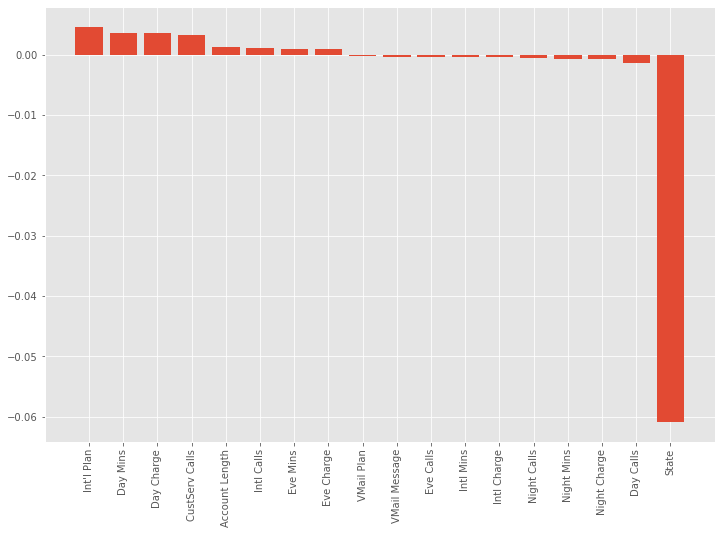

In [63]:
ind_nb,new_import_df_nb=get_importance(importance_nb)
plt.bar([x for x in range(len(new_import_df_nb))], new_import_df_nb[0])
plt.xticks([i for i in range(len(ind_nb))],ind_nb,rotation=90)
plt.show()

# Confusion Matrix Comparison 

In [64]:
cm_compare=pd.DataFrame([[dt_tp,dt_fn,nb_tp,nb_fn],[dt_fp,dt_tn,nb_fp,nb_tn],[dt_accuracy,np.nan,nb_accuracy,np.nan],[dt_recall,np.nan,nb_recall,np.nan],[dt_precision,np.nan,nb_precision,np.nan]],
                        index=pd.Index(['Churn','Not Churn','Accuracy','Recall','Precision'],name='Actual:'),
                        columns=pd.MultiIndex.from_product([['Decision Tree','Naive Bayes'],['Churn','Not Churn']],names=['Model:','Predicted']))
cm_compare=cm_compare.style.format('{:.2f}')

In [65]:
cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': [('font-style','italic'), ('color', 'darkgrey'), ('font-weight','normal')]
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': [('background-color','#000066'), ('color','white')]
}


In [66]:
cm_compare=cm_compare.set_table_styles([cell_hover, index_names, headers])

In [67]:
cm_compare=cm_compare.set_table_styles([
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level0', 'props': [('font-size', '1.5em')]},
    {'selector': 'td', 'props': [('text-align','center'), ('font-weight', 'bold')]}
], overwrite=False)

In [68]:
cm_compare=cm_compare.set_table_styles({
    ('Naive Bayes', 'Churn'): [{'selector': 'th', 'props': [('border-left','1px solid white')]},
                               {'selector': 'td', 'props': [('border-left','1px solid #000066')]}]
}, overwrite=False, axis=0)

In [69]:
cm_compare

# Find which attributes to build models

### Decision Tree

In [146]:
def visual_metrics(model,import_df):
    train_accuracies=[]
    test_accuracies=[]
    train_precisions=[]
    test_precisions=[]
    use_cols=[]
    features=import_df.index.tolist()
    for i in range(len(features),1,-1):
        use_features=features[:i]
        use_cols.append(len(use_features))
        X=df[use_features]
        if 'State' in use_features:
            X=pd.get_dummies(X,columns=['State'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
        if model=='Decision Tree':
            classifier=DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
        else:
            classifier=GaussianNB()
        classifier.fit(X_train,y_train)
        train_accuracies.append(accuracy_score(y_train,classifier.predict(X_train)))
        test_accuracies.append(accuracy_score(y_test,classifier.predict(X_test)))
        train_precisions.append(precision_score(y_train,classifier.predict(X_train)))
        test_precisions.append(precision_score(y_test,classifier.predict(X_test)))
    fig,(ax1,ax2)=plt.subplots(2)
    ax1.plot(use_cols,train_accuracies,'-o',label='Train')
    ax1.plot(use_cols,test_accuracies,'-o',label='Test')
    ax1.legend()
    ax1.invert_xaxis()
    ax1_y_max=max(test_accuracies)
    ax1_x=use_cols[test_accuracies.index(ax1_y_max)]
    ax1.annotate('Highest Accuracy ({} features used)'.format(ax1_x),xy=(ax1_x,ax1_y_max),xytext=(ax1_x, ax1_y_max+0.03),arrowprops=dict(facecolor='black', shrink=0.05))
    ax1.set_title('Accuracy of {}'.format(model))
    
    ax2.plot(use_cols,train_precisions,'-o',label='Train')
    ax2.plot(use_cols,test_precisions,'-o',label='Test')
    ax2.legend()
    ax2.invert_xaxis()
    ax2_y_max=max(test_precisions)
    ax2_x=use_cols[test_precisions.index(ax2_y_max)]
    ax2.annotate('Highest Precision ({} features used)'.format(ax2_x),xy=(ax2_x,ax2_y_max),xytext=(ax2_x, ax2_y_max+0.03),arrowprops=dict(facecolor='black', shrink=0.05))
    ax2.set_title('Precision of {}'.format(model))
    fig.show()

<ipython-input-146-07cd8f25563e>:42: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



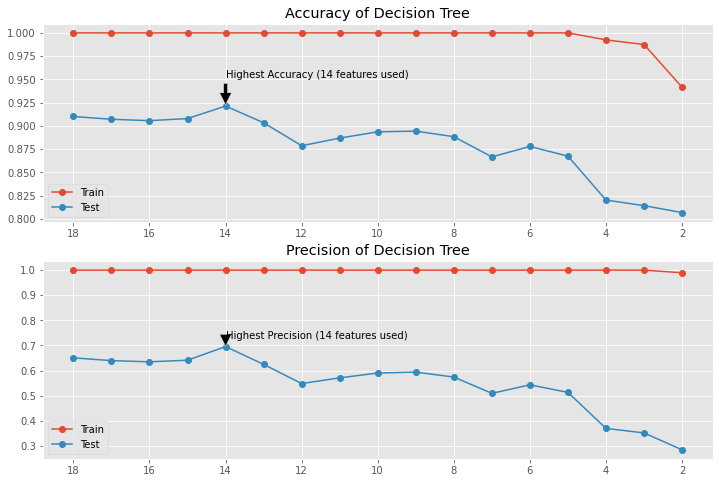

In [147]:
visual_metrics('Decision Tree',new_import_df_dt)

### Naive Bayes

In [144]:
import_nb=new_import_df_nb.apply(lambda x:abs(x))
import_nb=import_nb.sort_values(by=0,ascending=False)

<ipython-input-146-07cd8f25563e>:42: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



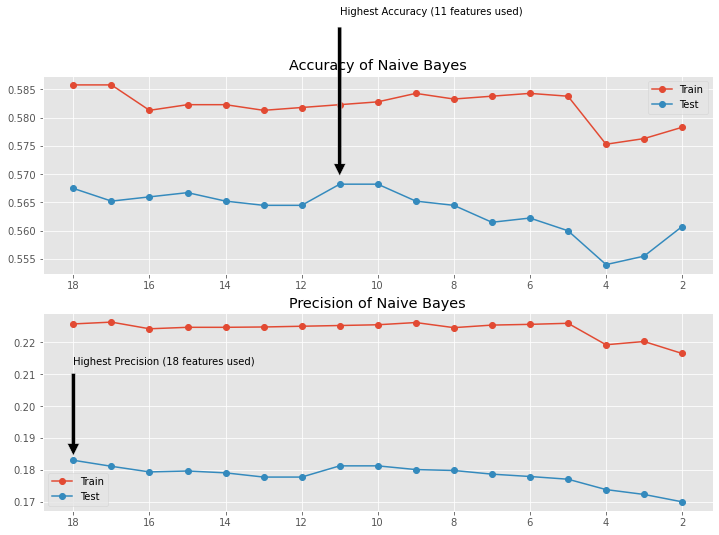

In [148]:
visual_metrics('Naive Bayes',import_nb)